In [1]:
# Least Squares using states expressed as excitations relative to a nuclear ground state
import csv
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

In [2]:
# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,2]
error = energyDF[2:,3]

# Construct a matrix containing the energy contributions from each Hamiltonian parameter to each nuclear state
E = np.empty([len(exp),len(backgroundHam)])
for i in range(len(backgroundHam)):
    E[:,i] = energyDF[2:,i+5]*backgroundHam[i]
print(E.shape)
#print(energyDF[2:,4])
#print(scipy.linalg.norm(energyDF[2:,4]-exp)/math.sqrt(len(exp)))

(202, 69)


In [3]:
# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
pInit = np.empty(len(backgroundHam))
pInit.fill(1)                         # Initial Hamiltonian parameter weights are all 1 (unfitted)
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*E[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (E[k,i]*E[k,j])/(error[k]**2)
        G[i,j] = gTot

In [4]:
# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,pInit)

35 vlc eRMS = 0.1693056002642728  pRMS =  0.27657582438014633
full SVD eRMS = 0.18864840097131094  pRMS = 0.6155229416263579


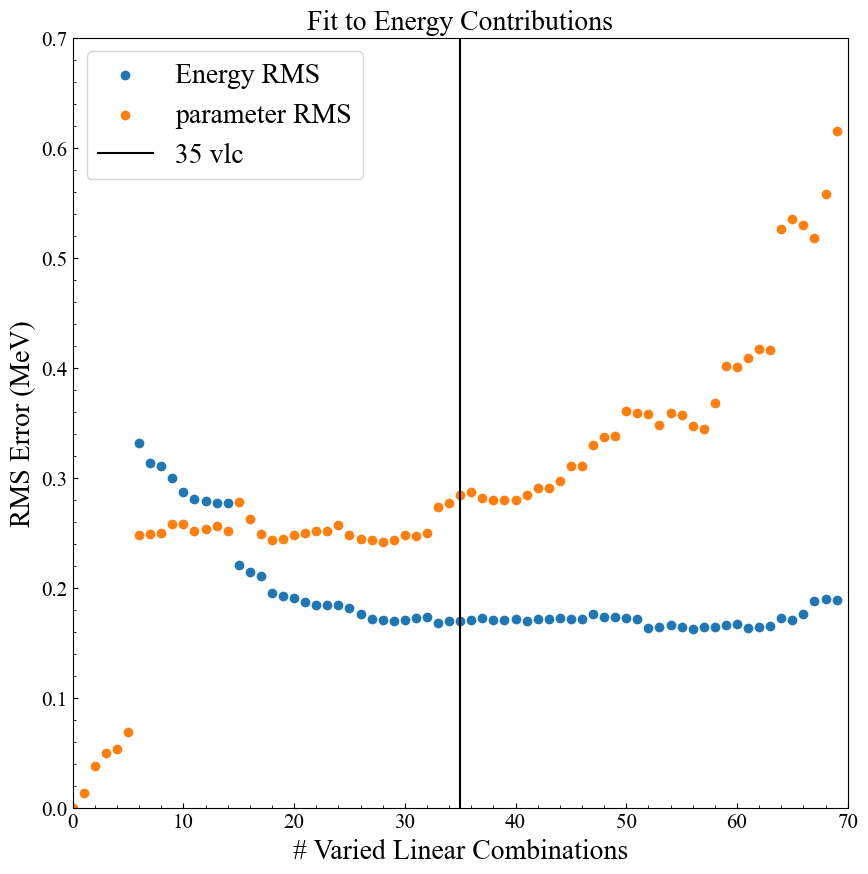

In [5]:
# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    fitEnergies = np.empty(len(exp))                    # Array for storing fitted energies in this iteration
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    pfit = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(backgroundHam)):       
        fitParameters[j] = pfit[j]*backgroundHam[j] # Modify our initial fit parameters by the new weights in pfit
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
    eResidual = exp - fitEnergies
    pResidual = backgroundHam - fitParameters
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in")
plt.legend(loc=2,fontsize=20)
plt.show()

In [6]:
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
for i in range(len(newHam)):
    newHam[i] = pfinal[i]*backgroundHam[i]
pRes = newHam-backgroundHam

for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
eRes = fitEnergies - exp
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(newHam-fittedHam)              # Difference between BAB Hamiltonian and my least squares


least squares energy RMS = 0.18864840097131094
least squares parameter RMS = 0.6155229437275077
[-1.01391763e-01 -1.09238871e-02  4.86835579e-02 -1.19854954e-01
  1.16848163e-02 -2.83257288e-01  5.24889017e-03 -5.76026531e-01
  6.67407872e-02 -4.83594522e-01 -7.75080450e-01 -2.87143613e-02
 -9.53845501e-02 -7.14456365e-01 -7.67062785e-01 -8.78720745e-01
 -2.41352820e-01 -1.92384246e-01  2.44720017e-01 -5.34510764e-02
 -9.16079504e-01  9.18716277e-01 -8.11477078e-01 -2.75405483e-02
 -2.83998995e-01  8.61601829e-01 -9.01528977e-01  1.59058196e-01
 -3.04547109e-01  9.59627663e-01 -5.27431875e-01 -4.66722421e-01
  7.02268934e-01 -4.26288840e-02 -3.49308969e-01 -2.13888761e-01
  3.43073492e-02  5.04816902e-01 -2.81547681e-01  4.29141433e-01
  7.02824931e-01  2.05073176e-01 -4.53290517e-01  5.22099809e-01
  7.16004359e-02  2.29259362e-03  4.29043544e-01 -2.88727765e+00
  4.36484670e-02 -7.58711344e-01 -4.02819169e-01  3.90048474e-01
  3.82452442e-01 -1.02389605e-01  7.22306775e-02  8.9178978

In [7]:
outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, newHam, newHam-fittedHam])

with open("outputs.dat","w") as f:
    f.write("Energy outputs   (0.189 MeV RMS for JP fit) \n")
    f.write("       exp      error        BAB         JP       Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("Parameter outputs (0.616 MeV RMS for JP fit) \n")
    f.write("BAB    JP    Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')
    f.write("\n")
    f.write("Elements of G: \n")
    np.savetxt(f, G, delimiter=' ', fmt='%15.4f')

In [8]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = np.empty(len(exp))
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    newExp[i] = exp[i]/error[i]
    for j in range(len(backgroundHam)):
        M[i,j] = E[i,j]/error[i]
lstSq = np.linalg.lstsq(M, newExp, rcond=None)

#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += lstSq[0][k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        lsEnergy[j] = eFitTot
eRes = lsEnergy - exp
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))

lsHam = np.empty(len(backgroundHam))
for i in range(len(lsHam)):
    lsHam[i] = lstSq[0][i]*backgroundHam[i]
print(lsHam-fittedHam)                                  # Difference between BAB Hamiltonian and my least squares

least squares energy RMS = 0.1886484006277269
[-1.01391758e-01 -1.09238978e-02  4.86835578e-02 -1.19854953e-01
  1.16848535e-02 -2.83257304e-01  5.24890008e-03 -5.76026477e-01
  6.67407822e-02 -4.83594548e-01 -7.75080494e-01 -2.87143589e-02
 -9.53845512e-02 -7.14456350e-01 -7.67062782e-01 -8.78720670e-01
 -2.41352820e-01 -1.92384246e-01  2.44720038e-01 -5.34510628e-02
 -9.16079477e-01  9.18716252e-01 -8.11477088e-01 -2.75405397e-02
 -2.83998993e-01  8.61601834e-01 -9.01528955e-01  1.59058196e-01
 -3.04547114e-01  9.59627638e-01 -5.27431866e-01 -4.66722432e-01
  7.02268927e-01 -4.26288858e-02 -3.49308934e-01 -2.13888748e-01
  3.43073480e-02  5.04816917e-01 -2.81547678e-01  4.29141432e-01
  7.02824904e-01  2.05073179e-01 -4.53290513e-01  5.22099806e-01
  7.16004358e-02  2.29259546e-03  4.29043545e-01 -2.88727765e+00
  4.36484639e-02 -7.58711343e-01 -4.02819177e-01  3.90048473e-01
  3.82452439e-01 -1.02389606e-01  7.22306791e-02  8.91789785e-02
  8.46412562e-02  9.95263385e-01  4.89676641